In [21]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

In [3]:
pna_file = '/home/averstyn/pna.data'
index_name = 'pna'

df=pd.read_table(pna_file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(3).index,inplace=True)

In [4]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'

In [5]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')

In [6]:
clim_index=df.T.unstack().values
clim_index = clim_index.astype('float32')

In [7]:
ds_index=xr.DataArray(clim_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_index=ds_index.to_dataset(name='pna')

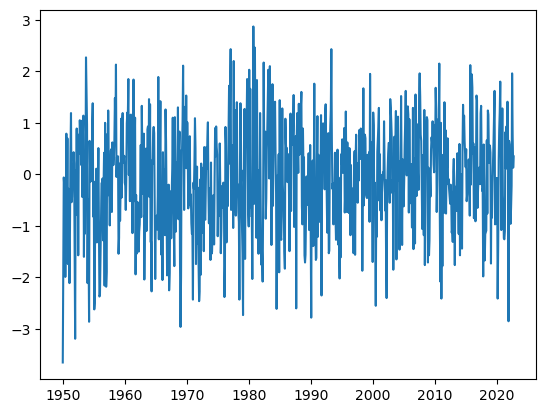

In [8]:
plt.plot(ds_index['time'],ds_index['pna'])

In [9]:
s5p_ds = xr.open_mfdataset('/home/averstyn/final_s5p/co/*.nc')

In [10]:
pospna = ds_index.where(ds_index>=0)
negpna = ds_index.where(ds_index<=0)

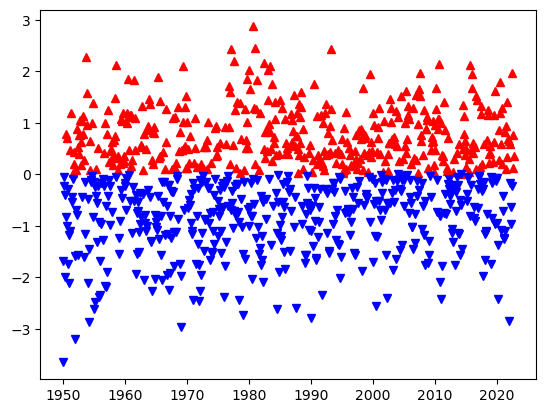

In [11]:
plt.plot(ds_index['time'],pospna['pna'],'r^')
plt.plot(ds_index['time'],negpna['pna'],'bv')

In [12]:
da_pna = ds_index.where(ds_index.time.isin(s5p_ds.time),drop=True)

In [13]:
pospna_g = da_pna.where(da_pna>=0)
negpna_g = da_pna.where(da_pna<0)

(-2.0, 2.0)

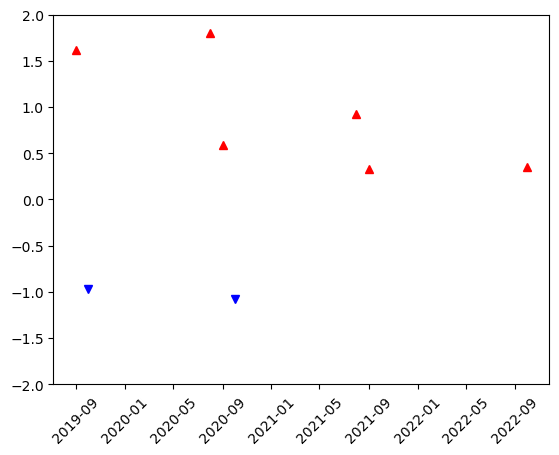

In [14]:
plt.plot(pospna_g['time'],pospna_g['pna'],'r^')
plt.plot(negpna_g['time'],negpna_g['pna'],'bv')
plt.xticks(rotation=45)
plt.ylim(-2,2)

In [15]:
print('Positive: ',pospna_g.count(dim='time').values)
print('Negative: ',negpna_g.count(dim='time').values)
counts=[pospna_g.count(dim='time').values,
        negpna_g.count(dim='time').values]
print(counts)

Positive:  <bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    pna      int64 6>
Negative:  <bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    pna      int64 2>
[<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    pna      int64 6>, <bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    pna      int64 2>]


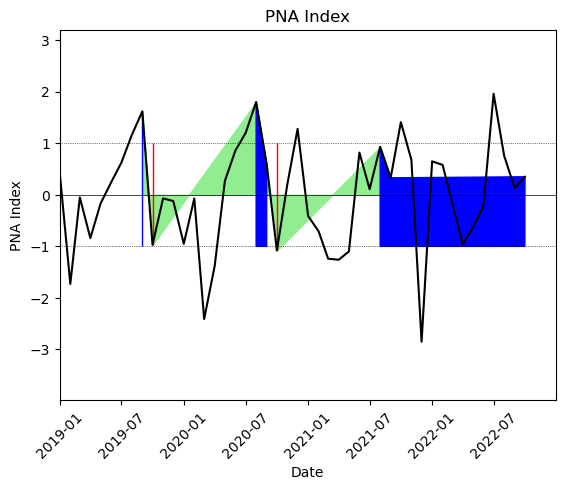

In [28]:
plt.plot(ds_index['time'],ds_index['pna'],'k')
plt.fill_between(da_pna['time'].values,da_pna['pna'],color='lightgreen')
plt.fill_between(da_pna['time'].values,negpna_g['pna'],y2=1.0,color='red')
plt.fill_between(da_pna['time'].values,pospna_g['pna'],y2=-1.0,color='blue')
plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(1,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-1,color='black',linewidth=0.5,linestyle='dotted') ;
plt.xlim([dt.date(2019, 1, 1), dt.date(2022, 12, 31)])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('PNA Index')
plt.title('PNA Index')
plt.savefig('/home/averstyn/CLIM680_final/composites.png')

In [90]:
ds_climo = s5p_ds.groupby('time.month').mean()
ds_anoms = s5p_ds.groupby('time.month') - ds_climo

In [91]:
da_co = s5p_ds['carbonmonoxide_total_column']

In [92]:
da_climo = da_co.groupby('time.month').mean()
da_anoms = da_co.groupby('time.month')-da_climo

In [93]:
negpna_co = da_anoms.sel(time=negpna_g.dropna(dim='time')['time']).mean(dim='time')
pospna_co = da_anoms.sel(time=pospna_g.dropna(dim='time')['time']).mean(dim='time')

comp_co = [negpna_co,pospna_co]

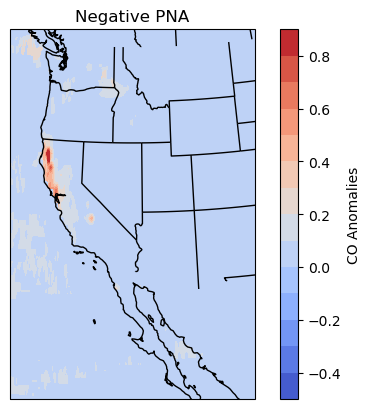

In [105]:
labels=['Negative PNA', 'Positve PNA']
clevs = np.arange(-0.5,1,0.1)

extent = [-125,-105,23,50]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Define the figure and each axis for the 3 rows and 3 columns
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon,central_lat))

states = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m',
                             facecolor='none')
              
neg_data = comp_co[0]
neg_data = neg_data*10

ax.set_extent(extent)

cs = ax.contourf(neg_data['lon'],neg_data['lat'],neg_data,transform=ccrs.PlateCarree(),cmap='coolwarm',levels=clevs)

ax.set_title('Negative PNA')

ax.coastlines()

ax.add_feature(states)

plt.colorbar(cs,label='CO Anomalies',extend='both')

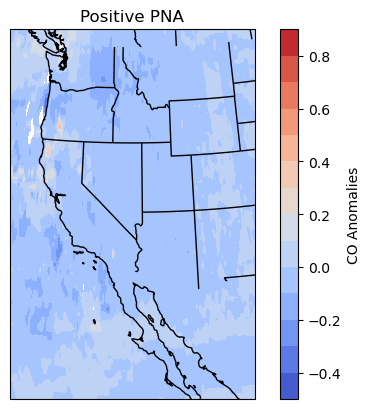

In [106]:
labels=['Negative PNA', 'Positve PNA']
clevs = np.arange(-0.5,1,0.1)

extent = [-125,-105,23,50]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Define the figure and each axis for the 3 rows and 3 columns
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon,central_lat))

states = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m',
                             facecolor='none')
              
pos_data = comp_co[1]
pos_data = pos_data*10

ax.set_extent(extent)

cs = ax.contourf(pos_data['lon'],pos_data['lat'],pos_data,transform=ccrs.PlateCarree(),cmap='coolwarm',levels=clevs)

ax.set_title('Positive PNA')

ax.coastlines()

ax.add_feature(states)

plt.colorbar(cs,label='CO Anomalies')